## importing libraries and data

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/man-juu/datasetML/main/language_detection_dataset.csv")
data.head(21)

,Text,Language
0,oyama station was opened on april the statio...,English
1,elle est la fille de gérios tuéni et katbé sur...,French
2,"en participó en el video ""love machine"" donde...",Spanish
3,o rondonópolis e o goiás são os únicos times d...,Portuguese
4,immagino che non vorrebbe più pane d'oro adess...,Italian
5,мая года был назначен тренером вратарей сбор...,Russian
6,cerro wichu kkollu är ett berg i bolivia det l...,Swedish
7,ടെറി നിങ്ങൾ യഥാർത്ഥത്തിൽ ആ മാലാഖയെപ്പോലെയാണ് ക...,Malayalam
8,francisco de miranda is een gemeente in de ven...,Dutch
9,في أبريل م قدم الزعيم مصطفى النحاس مذكرة للسف...,Arabic


In [ ]:
data["Language"].value_counts()

English       901
French        901
Spanish       820
Portuguese    740
Italian       697
Russian       693
Swedish       677
Malayalam     594
Dutch         547
Arabic        537
Turkish       475
German        470
Tamil         469
Danish        428
Kannada       369
Greek         365
Chinese       301
Indonesian    301
Japanese      301
Korean        301
Hindi         113
Name: Language, dtype: int64

In [ ]:
X = data["Text"]
y = data["Language"]

## data preprocessing

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
data_list = []
for x in X:
        # removing the symbols and numbers
        x = re.sub(r'[!@#$(),n"%^*?:;~`0-9]', ' ', x)
        x = re.sub(r'[[]]', ' ', x)
        # converting the text to lower case
        x = x.lower()
        #remove mentions
        x = re.sub('@\S+' , ' ' , x)
        #remove url
        x = re.sub('https*\S+' , ' ' , x)
        #remove hastag
        x= re.sub('#\S+' , ' ' , x)
        # appending to data_list
        data_list.append(x)

### convert to BoW

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(data_list).toarray()
X.shape

(11000, 58874)

## train test splitting

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

## building model

In [ ]:
class Multinomial:
  def __init__(self,alpha=1):
    self.alpha = alpha
    
  def _prior(self):
    P = np.zeros((self.n_classes_))
    _, self.dist = np.unique(self.y,return_counts=True)
    for i in range(self.classes_.shape[0]):
        P[i] = self.dist[i] / self.n_samples
    return P
    

  def fit(self, X, y):
    self.X = X
    self.y = y
    self.n_samples, self.n_features = X.shape
    self.classes_ = np.unique(y)
    self.n_classes_ = self.classes_.shape[0]
    self.class_priors_ = self._prior()
    
    self.uniques = []
    for i in range(self.n_features):
        tmp = np.unique(X[:,i])
        self.uniques.append( tmp )
        
    self.N_yi = np.zeros((self.n_classes_, self.n_features))
    self.N_y = np.zeros((self.n_classes_)) 
    for i in self.classes_:
        indices = np.argwhere(self.y==i).flatten()
        columnwise_sum = []
        for j in range(self.n_features):
            columnwise_sum.append(np.sum(X[indices,j]))
            
        self.N_yi[i] = columnwise_sum
        self.N_y[i] = np.sum(columnwise_sum)
    

  def _theta(self, x_i, i, h):
    Nyi = self.N_yi[h,i]
    Ny  = self.N_y[h]
    
    numerator = Nyi + self.alpha
    denominator = Ny + (self.alpha * self.n_features)
    
    return  (numerator / denominator)**x_i
  

  def _likelyhood(self, x, h):
    tmp = []
    for i in range(x.shape[0]):
        tmp.append(self._theta(x[i], i,h))
    
    return np.prod(tmp)
  

  def predict(self, X):
    samples, features = X.shape
    self.predict_proba = np.zeros((samples,self.n_classes_))
    
    for i in range(X.shape[0]):
        joint_likelyhood = np.zeros((self.n_classes_))
        
        for h in range(self.n_classes_):
            joint_likelyhood[h]  = self.class_priors_[h] * self._likelyhood(X[i],h)
            
        denominator = np.sum(joint_likelyhood)
        
        for h in range(self.n_classes_):
            numerator = joint_likelyhood[h]
            self.predict_proba[i,h] = (numerator / denominator)
        
    indices = np.argmax(self.predict_proba,axis=1)
    return self.classes_[indices]

## implement model

In [ ]:
model = Multinomial()
model.fit(x_train, y_train)

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
modelnb = MultinomialNB()
modelnb.fit(x_train, y_train)
y_predsk = modelnb.predict(x_test)

## evaluation

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
ac = accuracy_score(y_test, y_pred)
acl = accuracy_score(y_test, y_predsk)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy scratch is :",ac)
print("Accuracy library is :",acl)

Accuracy scratch is : 0.9268181818181818
Accuracy library is : 0.9459090909090909


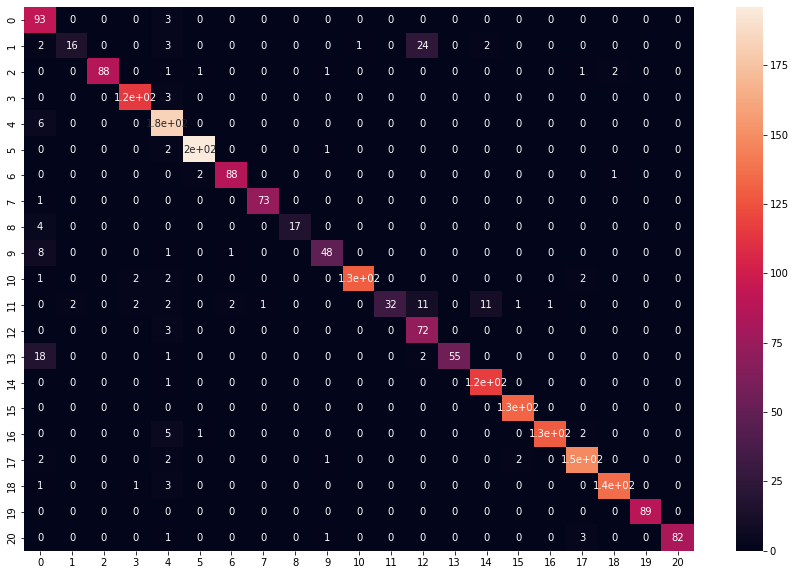

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot = True)
plt.show()

## predicting text

In [ ]:
def predict(text):
     x = cv.transform([text]).toarray() # converting text to bag of words model (Vector)
     lang = model.predict(x) # predicting the language
     lang = le.inverse_transform(lang) # finding the language corresponding the the predicted value
     print("The language is in",lang[0]) # printing the language

In [ ]:
predict("Where is this? Who am i?")

The language is in English


In [ ]:
predict("أين هذا؟ من أنا؟")

The language is in Arabic


In [ ]:
predict("¿donde está esto? ¿quién soy?")

The language is in Spanish


In [ ]:
predict("dov'è questo? chi sono?")

The language is in Italian


In [ ]:
predict("wo ist das? Wer bin ich?")

The language is in German


In [ ]:
predict("இது எங்கு இருக்கிறது? நான் யார்?")

The language is in Tamil


In [ ]:
predict("где это? кто я?")

The language is in Russian


In [ ]:
predict("ここはどこ?私は誰?")

The language is in Japanese


In [ ]:
predict("Ini dimana? Siapa saya?")

The language is in Indonesian


In [ ]:
predict("यह कहां है? मैं कौन हूँ?")

The language is in Hindi


In [ ]:
predict("моје име је Виллиам")
# This is Serbian (not in dataset)

The language is in English


### predict with user input

In [ ]:
#text = input("Input Sentence: ")
#predict(text)